In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = '/content/drive/MyDrive/CDC_DS_PROJECT'

Training only tabular data

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import os
import sys
import warnings
warnings.filterwarnings('ignore')

Loading processed tabular data

In [ ]:
train_df = pd.read_csv(f'{path}/fully_processed_train_data.csv')

In [ ]:
train_df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,total_rooms,living_vs_neighbors
0,9117000170,20150505T000000,268643,4,2.25,-0.211945,-0.137644,2.0,0,0,...,-0.650737,1961,0,98055,47.4362,-122.187,-0.426951,-0.121204,6.25,1.090361
1,6700390210,20140708T000000,245000,3,2.50,-0.484526,-0.307116,2.0,0,0,...,-0.650737,1992,0,98031,47.4034,-122.187,-0.329329,-0.331014,5.50,0.930233
2,7212660540,20150115T000000,200000,4,2.50,-0.328765,-0.153457,2.0,0,0,...,-0.650737,1994,0,98003,47.2704,-122.313,-0.085273,-0.187666,6.50,0.919786
3,8562780200,20150427T000000,352499,2,2.25,-0.951808,-0.361829,2.0,0,0,...,-0.429362,2009,0,98027,47.5321,-122.073,-1.110309,-0.437315,4.25,1.000000
4,7760400350,20141205T000000,232000,3,2.00,-0.899888,-0.029531,1.0,0,0,...,-0.650737,1994,0,98042,47.3715,-122.074,-0.540844,-0.164730,5.00,0.805031


In [ ]:
test_df = pd.read_csv(f'{path}/fully_processed_test_data.csv')

<Axes: xlabel='price', ylabel='Count'>

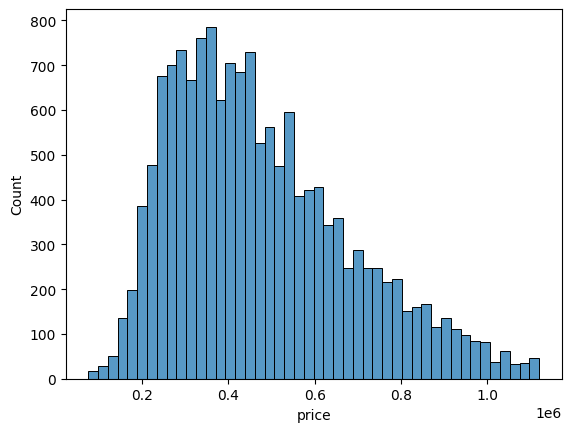

In [ ]:
sns.histplot(train_df['price'])

In [ ]:
train_df['price'] = np.log(train_df['price'])#handle skewness in data

<Axes: xlabel='price', ylabel='Count'>

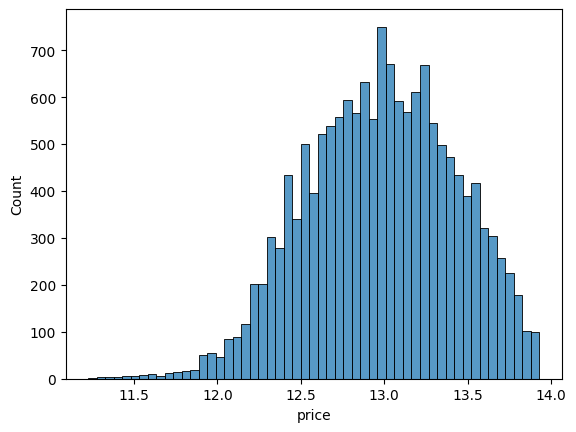

In [ ]:
sns.histplot(train_df['price'])

Creating some new features

In [ ]:
# House age
CURRENT_YEAR = 2012
train_df["house_age"] = CURRENT_YEAR - train_df["yr_built"]
# Renovation indicator
train_df["renovated"] = (train_df["yr_renovated"] > 0).astype(int)

In [ ]:
Tabular_features = [ 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement',  'lat', 'long', 'sqft_living15', 'sqft_lot15', 'total_rooms',
       'living_vs_neighbors','house_age', 'renovated']

In [ ]:
X = train_df[Tabular_features]
y = train_df['price']

Training multiple regression model to find best one

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=42)

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [ ]:
# Linear Regression
lr = LinearRegression()
lr.fit(X_train,y_train)

# Random Forest
rf = RandomForestRegressor(n_estimators=200,random_state=42)
rf.fit(X_train, y_train)

# XGBoost
xgb = XGBRegressor( n_estimators=300, learning_rate=0.05, max_depth=6,random_state=42)
xgb.fit(X_train, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=300,
             n_jobs=None, num_parallel_tree=None, ...)

Comparing models

In [ ]:
models = {
    "Linear Regression": lr,
    "Random Forest": rf,
    "XGBoost": xgb
}

results = []

for name, model in models.items():
    y_pred = model.predict(X_test)

    results.append({
        "Model": name,
        "MAE": mean_absolute_error(y_test, y_pred),
        "RMSE": np.sqrt(mean_squared_error(y_test, y_pred)),
        "R2": r2_score(y_test, y_pred)
    })

results_df = pd.DataFrame(results)
print(results_df)


               Model       MAE      RMSE        R2
0  Linear Regression  0.189400  0.244591  0.701900
1      Random Forest  0.122760  0.175890  0.845844
2            XGBoost  0.116168  0.165026  0.864298


Best model is XGBoost for training only tabular data

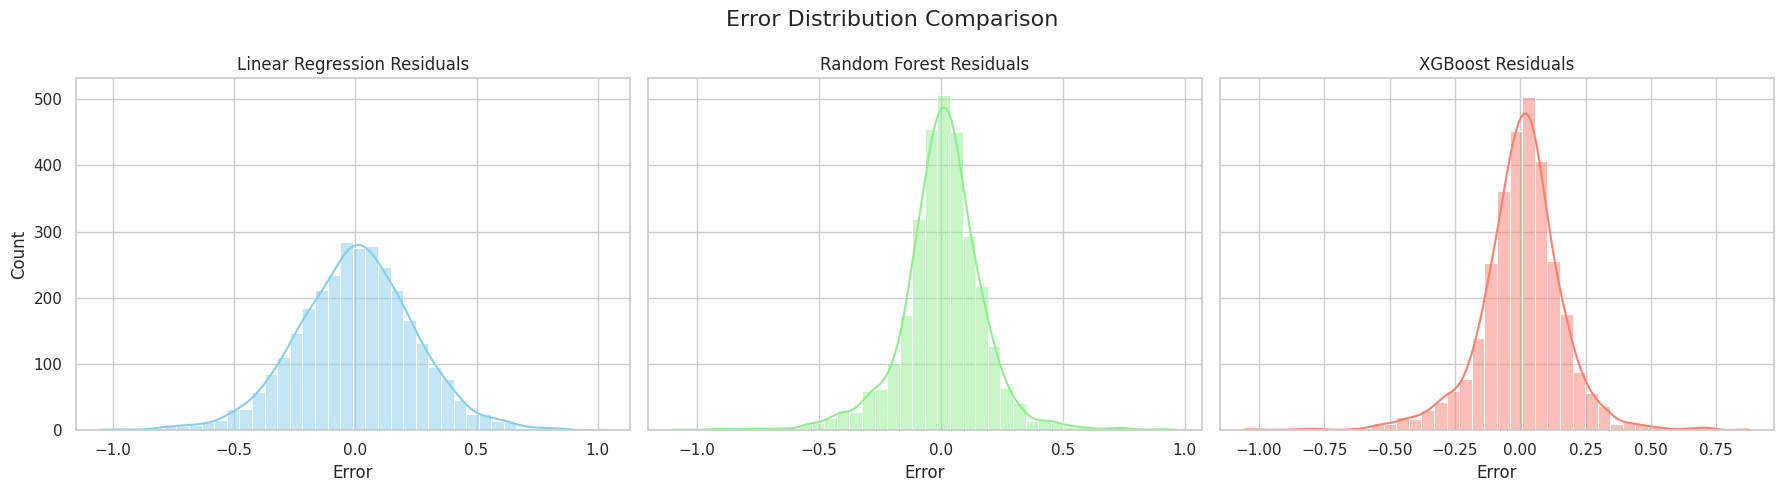

In [ ]:
y_pred_lr = lr.predict(X_test)
y_pred_rf = rf.predict(X_test)
y_pred_xgb = xgb.predict(X_test)

# Residuals
res_lr = y_test - y_pred_lr
res_rf = y_test - y_pred_rf
res_xgb = y_test - y_pred_xgb

sns.set(style="whitegrid")

fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

# Linear Regression
sns.histplot(res_lr, bins=40, kde=True, ax=axes[0], color="skyblue")
axes[0].set_title("Linear Regression Residuals")
axes[0].set_xlabel("Error")

# Random Forest
sns.histplot(res_rf, bins=40, kde=True, ax=axes[1], color="lightgreen")
axes[1].set_title("Random Forest Residuals")
axes[1].set_xlabel("Error")

# XGBoost
sns.histplot(res_xgb, bins=40, kde=True, ax=axes[2], color="salmon")
axes[2].set_title("XGBoost Residuals")
axes[2].set_xlabel("Error")

plt.suptitle("Error Distribution Comparison", fontsize=16)
plt.tight_layout()
plt.show()